<a href="https://colab.research.google.com/github/axk817/RIT_IMGS789/blob/main/HW2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
# MNIST dataset
(x_train, _), (x_test, y_test) = keras.datasets.mnist.load_data()

In [8]:
# Preprocessing
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [9]:
# Shuffle the training data
shuffled_indices = np.random.permutation(len(x_train))
x_train = x_train[shuffled_indices]

In [10]:
# VAE model
latent_dim = 4
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [11]:
#Latent space and Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim),
                                            mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [12]:
class VAE(keras.Model):
    """
    Variational Autoencoder (VAE) model.

    This class defines the VAE model, including the encoder, decoder,
    loss functions, and training step.
    """
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initializes the VAE model.

        Args:
          encoder: The encoder network.
          decoder: The decoder network.
          **kwargs: Keyword arguments for the keras.Model class.
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Metrics to track during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Returns a list of metrics to be tracked during training.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Performs a single training step.

        Args:
          data: The input data for the VAE.

        Returns:
          A dictionary containing the loss values for the current step.
        """
        with tf.GradientTape() as tape:
            # Encode the input data
            z_mean, z_log_var, z = self.encoder(data)
            # Decode the latent representation
            reconstruction = self.decoder(z)
            # Calculate the reconstruction loss (binary cross-entropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # Calculate the KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Calculate the total loss
            total_loss = reconstruction_loss + kl_loss
        # Compute gradients and apply them to update the model's weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the metric trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return the current loss values
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Create a VAE instance
vae = VAE(encoder, decoder)

In [13]:
#Training the VAE and saving the loss values
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 12s 23ms/step - loss: 266.0714 - reconstruction_loss: 209.7042 - kl_loss: 4.1149
Epoch 2/30
469/469 [==============================] - 11s 23ms/step - loss: 168.2899 - reconstruction_loss: 154.3472 - kl_loss: 8.2872
Epoch 3/30
469/469 [==============================] - 11s 23ms/step - loss: 153.9935 - reconstruction_loss: 144.0329 - kl_loss: 8.7681
Epoch 4/30
469/469 [==============================] - 11s 23ms/step - loss: 150.2726 - reconstruction_loss: 140.9960 - kl_loss: 8.8495
Epoch 5/30
469/469 [==============================] - 11s 23ms/step - loss: 148.6409 - reconstruction_loss: 139.1808 - kl_loss: 8.8803
Epoch 6/30
469/469 [==============================] - 11s 23ms/step - loss: 147.1283 - reconstruction_loss: 137.8087 - kl_loss: 8.8684
Epoch 7/30
469/469 [==============================] - 10s 22ms/step - loss: 145.7975 - reconstruction_loss: 136.8790 - kl_loss: 8.8726
Epoch 8/30
469/469 [==============================] - 1

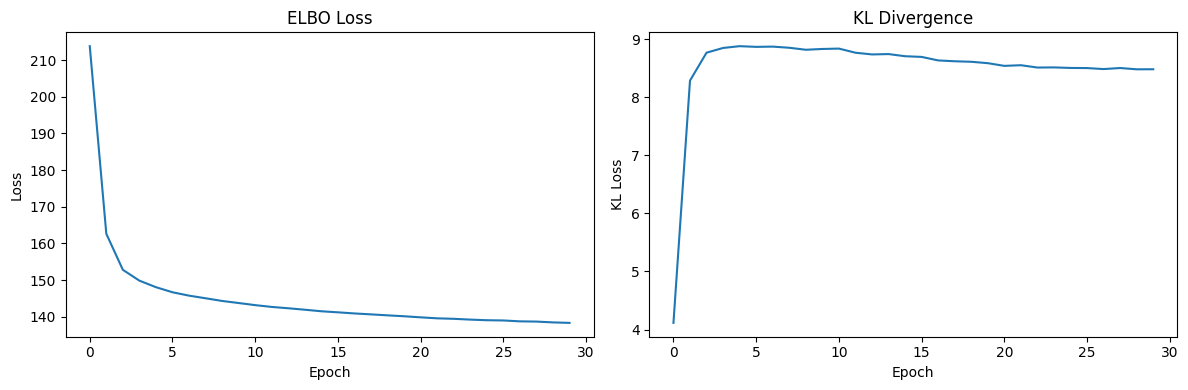

In [14]:
plt.figure(figsize=(12, 4))

# ELBO loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('ELBO Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# KL Divergence
plt.subplot(1, 2, 2)
plt.plot(history.history['kl_loss'])
plt.title('KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step


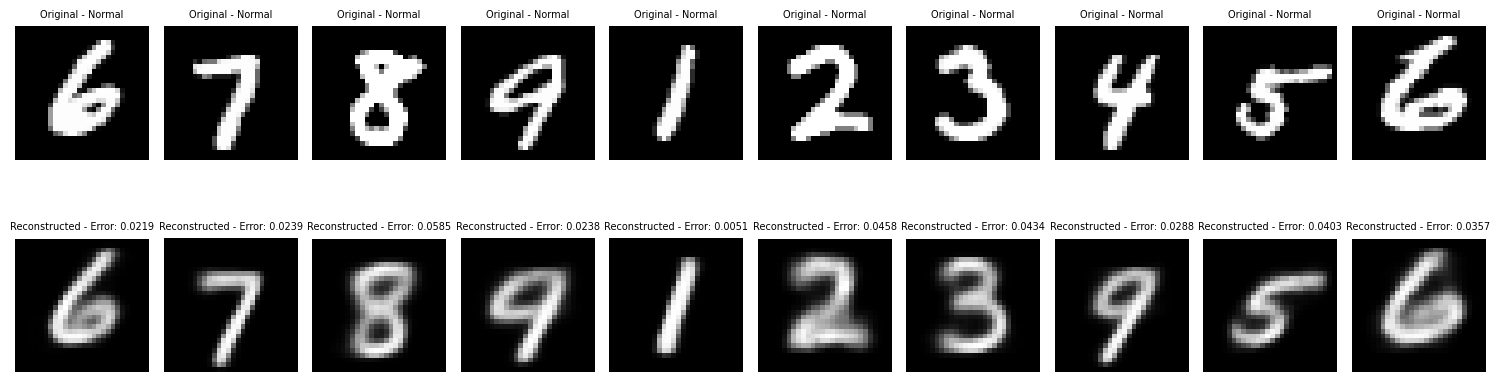

In [33]:
#Visualize the original and reconstructed images
def visualize_reconstructions(original_images, reconstructed_images, errors, labels, num_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title(f"Original - {labels[i]}", fontsize=7)
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title(f"Reconstructed - Error: {errors[i]:.4f}", fontsize=7)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Select 10 normal images
normal_indices = np.where(y_pred_normal == 1)[0][-10:]  # Or use any other selection method

# Get original and reconstructed images (only normal images)
original_images = x_test[normal_indices]
z_mean, _, _ = vae.encoder.predict(original_images)
reconstructed_images = vae.decoder.predict(z_mean)
errors = reconstruction_errors_normal[normal_indices]
labels = ['Normal'] * 10

# Visualize
visualize_reconstructions(original_images, reconstructed_images, errors, labels)

In [15]:
# Calculate the reconstruction error in Anomaly detection
def calculate_reconstruction_error(images):
    z_mean, z_log_var, z = vae.encoder.predict(images)
    reconstructions = vae.decoder.predict(z)
    reconstruction_errors = np.mean(np.square(reconstructions - images), axis=(1, 2, 3))
    return reconstruction_errors

In [16]:
# Generate anomalous images (add noise)
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [17]:
# Calculate reconstruction errors
reconstruction_errors_normal = calculate_reconstruction_error(x_test)
reconstruction_errors_anomalous = calculate_reconstruction_error(x_test_noisy)

313/313 [==============================] - 1s 4ms/step


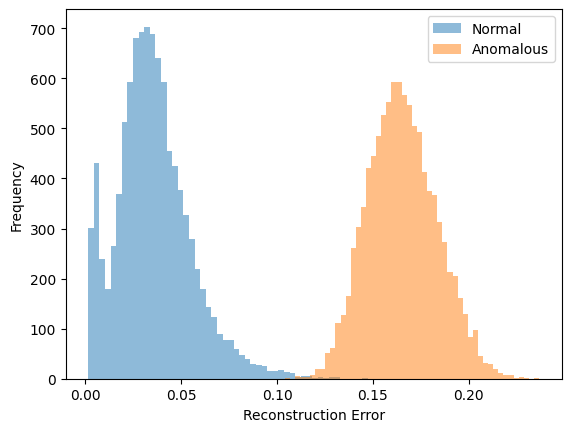

In [19]:
# Plot distribution of reconstruction errors
plt.hist(reconstruction_errors_normal, bins=50, alpha=0.5, label='Normal')
plt.hist(reconstruction_errors_anomalous, bins=50, alpha=0.5, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
# Set a percentile threshold for normal and anomalous images
threshold = np.percentile(reconstruction_errors_normal, 95) # Example threshold

In [21]:
# Classify images
y_pred_normal = (reconstruction_errors_normal <= threshold).astype(int)
y_pred_anomalous = (reconstruction_errors_anomalous > threshold).astype(int)

1/1 [==============================] - 0s 26ms/step


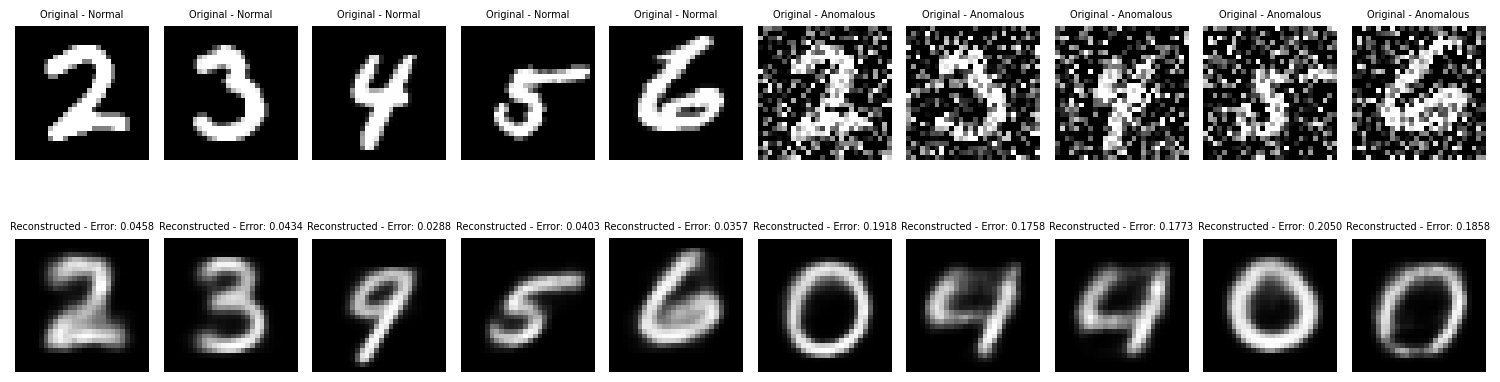

In [31]:
#Visualize the reconstructed normal and anomalous images in comparison to the original images

# Select some normal and anomalous images
normal_indices = np.where(y_pred_normal == 1)[0][-5:]
anomalous_indices = np.where(y_pred_anomalous == 1)[0][-5:]

# Get original and reconstructed images
original_images = np.concatenate((x_test[normal_indices], x_test_noisy[anomalous_indices]))
z_mean, _, _ = vae.encoder.predict(original_images)
reconstructed_images = vae.decoder.predict(z_mean)
errors = np.concatenate((reconstruction_errors_normal[normal_indices], reconstruction_errors_anomalous[anomalous_indices]))
labels = ['Normal'] * 5 + ['Anomalous'] *5

# Visualize
visualize_reconstructions(original_images, reconstructed_images, errors, labels)

313/313 [==============================] - 1s 2ms/step


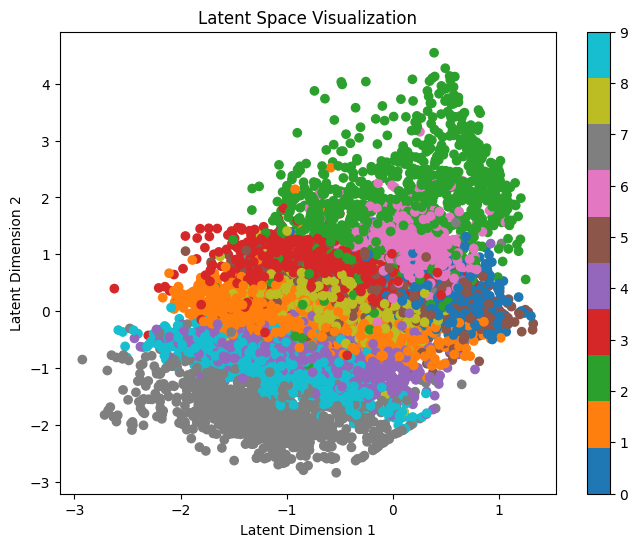

In [26]:
# Visualize latent space
def visualize_latent_space(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

# Visualize latent space of test data
visualize_latent_space(vae.encoder, x_test, y_test)  # Assuming you have y_test labels